In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical
from keras import callbacks

Using TensorFlow backend.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [5]:
import util, defs, models

In [8]:
import energyflow as ef
from energyflow.archs import PFN

In [6]:
bg_consts, sig_consts, bg_jets, sig_jets = util.load_data()
    
print(bg_consts.shape)
print(sig_consts.shape)

(297233, 96, 3)
(392759, 96, 3)


In [7]:
(X_train, y_train), (X_val, y_val) = util.format_dataset(bg_consts, sig_consts,
                                                         validation_fraction=defs.VALIDATION_FRACTION)

print("Training set:  ", X_train.shape)
print("Validation set:", X_val.shape)

Training set:   (505298, 96, 3)
Validation set: (89168, 96, 3)


In [405]:
K.clear_session()

pfn = models.mk_PFN(**defs.BENCHMARK_PFN_ARGS)

pfn.h = util.HistoryCB(val_data=(X_val, y_val))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 256)    1280        input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 256)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 256)    65792       activation_1[0][0]               
____________________________________________________________________________________________

In [478]:
epochs = 4

batch_size = 512 #128

learning_rate = 1e-3 #3e-4


K.set_value(pfn.optimizer.lr, learning_rate)


stopping = callbacks.EarlyStopping(monitor='val_loss', patience=32, verbose=2,
                                   mode='min', restore_best_weights=True)

try:
    pfn.fit(X_train, y_train,
                     validation_data=(X_val, y_val),
                     callbacks=[pfn.h],
                     batch_size=batch_size,
                     epochs=epochs
                    )
except KeyboardInterrupt:
    pass

Train on 505298 samples, validate on 89168 samples
Epoch 1/4
505298/505298 [==============================] - 23s 46us/step - loss: 0.5117 - val_loss: 0.5266
Epoch 2/4
505298/505298 [==============================] - 24s 47us/step - loss: 0.5115 - val_loss: 0.5243
Epoch 3/4
505298/505298 [==============================] - 24s 47us/step - loss: 0.5115 - val_loss: 0.5266
Epoch 4/4
505298/505298 [==============================] - 24s 47us/step - loss: 0.5111 - val_loss: 0.5253


Validation AUC: 0.8156842711378645
          best: 0.8173271006365959
         ibest: 79/92


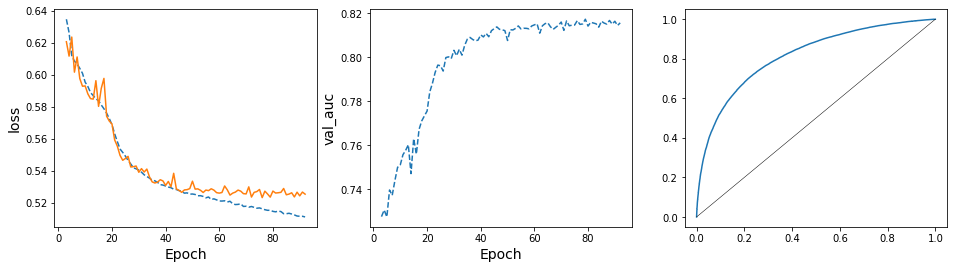

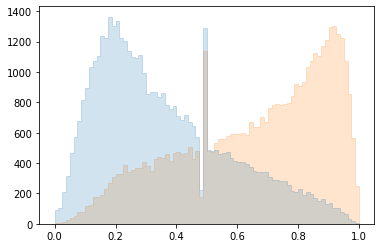

In [479]:
pfn.h.plot(['loss', 'val_auc', 'roc'], nskip=2,
                    figsize=plt.figaspect(0.25))
print("Validation AUC:", pfn.h.history['val_auc'][-1])
print("          best:", np.max(pfn.h.history['val_auc']))
print("         ibest: %d/%d"%(np.argmax(pfn.h.history['val_auc'])+1, pfn.h.epoch_total))

plt.figure()
preds_val = pfn.predict(X_val, batch_size=512).squeeze()
plt.hist([preds_val[y_val==0], preds_val[y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2);

In [470]:
do_save = False
if do_save:
    pfn.nonaug.save('model_benchmark_PFN_wierd.h5')

In [468]:
# best*: 0.817 5x256 no drop +phi (lr=1e-3, bs=512)  *but NN output distribution looks weird
# best: 0.814 4x256 no drop, +phi (lr=1e-3, bs=512)
# best: 0.805 3x256 no drop, +phi (lr=3e-4, bs=512)
# best: 0.789 2x256 no drop, +phi (lr=3e-4. bs=512)

/ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


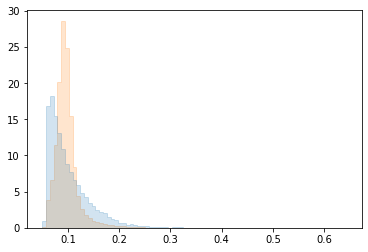

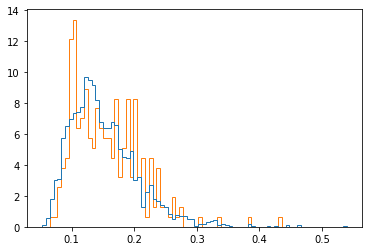

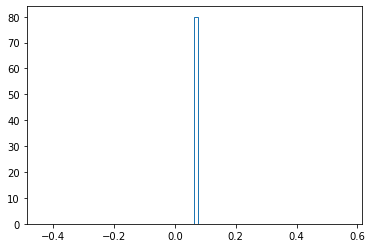

In [162]:
plt.hist([HL_val[:,3][y_val==0], HL_val[:,3][y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2, density=True);
plt.figure()
plt.hist([HL_val[:,3][(y_val==0)*(preds_val<0.2)], HL_val[:,3][(y_val==1)*(preds_val<0.2)]], histtype='step', bins=80, density=True);
plt.figure()
plt.hist([HL_val[:,3][(y_val==0)*(preds_val>0.8)], HL_val[:,3][(y_val==1)*(preds_val>0.8)]], histtype='step', bins=80, density=True);

0.026155412197113037
0.42326484620571136
0.5250938057899475
0.6164753079414368
0.6557076305150985
0.7037486743927002


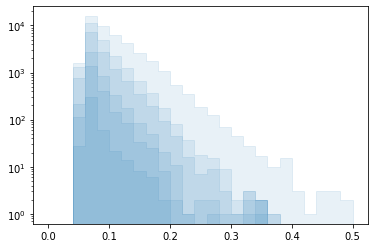

In [163]:
for q in np.quantile(preds_val[y_val==0], (0,0.5,0.7,0.9,0.95,0.99)):
    print(q)
    plt.hist(HL_val[:,3][(y_val==0)*(preds_val>q)], histtype='step', bins=25, range=(0,0.5), color='C0', alpha=0.1, fill=True)
plt.yscale('log');

0.7958492636680603
0.5699610710144043
0.5073096513748169
0.375879830121994
0.31820842027664187
0.22224053710699085


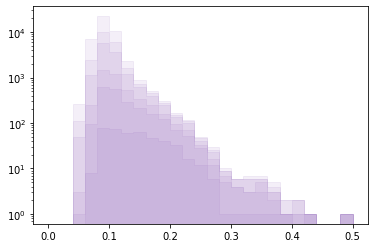

In [164]:
for q in np.quantile(preds_val[y_val==1], (1-0.0,1-0.5,1-0.7,1-0.9,1-0.95,1-0.99)):
    print(q)
    plt.hist(HL_val[:,3][(y_val==1)*(preds_val<q)], histtype='step', bins=25, range=(0,0.5), color='C4', alpha=0.1, fill=True)
plt.yscale('log');

In [44]:
save_model = False

if save_model:
    if shuffle_particles:
        file_name = 'model_benchmark_LL_shuff.h5'
    else:
        file_name = 'model_benchmark_LL.h5'
    
    benchmark_LL_nonaug.save(file_name)
    print("Saved to", file_name)